In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import special, integrate

sys.path.insert(0, '/home/aew492/CFE_gradients/code')
from generate_mock_list import MockSet

In [3]:
data_dir = '/scratch/aew492/CFE_gradients_output'

#### fiducial mock galaxy catalog set: $L=750\ \mathrm{Mpc}/h$, $n=2\times 10^{-4}\ \mathrm{gal}/(\mathrm{Mpc}/h)^3$

In [4]:
# generate mock set
L = 750
n = '2e-4'
As1 = 1   # overall clustering amplitude
As2 = 2
nmocks = 1000
mockset1 = MockSet(L, n, As=As1, data_dir=data_dir, rlzs=nmocks)
mockset2 = MockSet(L, n, As=As2, data_dir=data_dir, rlzs=nmocks)

## EMPIRICAL RESULTS: $\,\Delta\xi^2(r)$

In [5]:
mockset1.load_xi_lss()
r1 = mockset1.r_avg
xi_avg1 = np.mean(mockset1.xi_lss, axis=0)
xi_std1 = np.std(mockset1.xi_lss, axis=0)
xi_var1 = np.var(mockset1.xi_lss, axis=0)
print(r1.shape, xi_avg1.shape, xi_std1.shape)

(22,) (22,) (22,)


In [6]:
mockset2.load_xi_lss()
r2 = mockset2.r_avg
xi_avg2 = np.mean(mockset2.xi_lss, axis=0)
xi_std2 = np.std(mockset2.xi_lss, axis=0)
xi_var2 = np.var(mockset2.xi_lss, axis=0)
print(r2.shape, xi_avg2.shape, xi_std2.shape)

(22,) (22,) (22,)


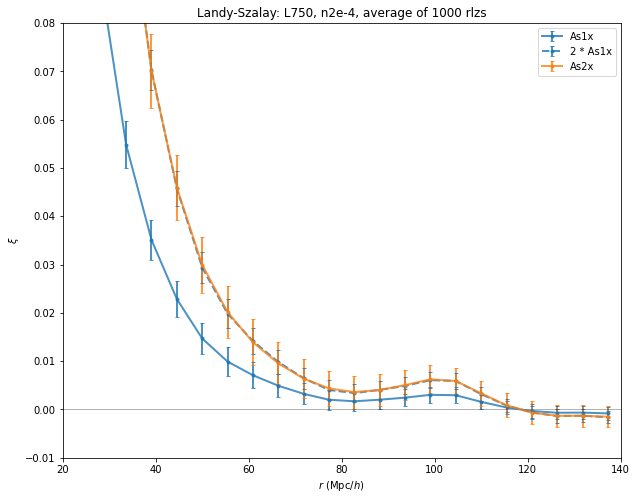

In [7]:
fig, ax = plt.subplots(figsize=(10,8))

ax.errorbar(r1, xi_avg1, xi_std1, marker='.', capsize=2, lw=2, color='C0', alpha=0.8, label='As1x')
ax.errorbar(r1, 2*xi_avg1, xi_std1, marker='.', capsize=2, lw=2, color='C0', ls='--', alpha=0.8, label='2 * As1x')
ax.errorbar(r2, xi_avg2, xi_std2, marker='.', capsize=2, lw=2, color='C1', alpha=0.8, label='As2x')

ax.axhline(0, color='k', lw=1, alpha=0.3)
ax.set_xlim((20,140))
ax.set_ylim((-.01,0.08))
ax.set_xlabel(r'$r$ (Mpc/$h$)')
ax.set_ylabel(r'$\xi$')
ax.set_title(f'Landy-Szalay: L{int(L)}, n{n}, average of {nmocks} rlzs')
ax.legend()

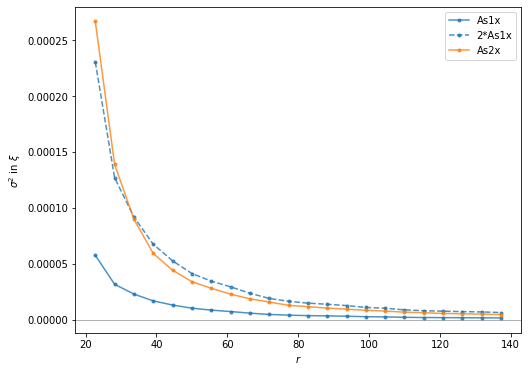

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(r1, xi_var1, marker='.', color='C0', alpha=0.8, label='As1x')
ax.plot(r1, 4*xi_var1, marker='.', color='C0', ls='--', alpha=0.8, label='2*As1x')
ax.plot(r2, xi_var2, marker='.', color='C1', alpha=0.8, label='As2x')
ax.axhline(0, color='k', lw=1, alpha=0.3)

ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$\sigma^2$ in $\xi$')
ax.legend()

The standard deviation in $\xi$ for As2x is twice that of As1x, so it looks like the $\textit{standard deviation}$ in $\xi$ varies linearly with the input overall clustering amplitude.

## PREDICTED RESULTS: $\,\Delta\xi^2(r)$

The equation given by Roman for the variance in the two-point correlation function:
$$
\Delta\xi^2(r) = \frac{1}{2\pi V} \int \frac{k\ dk}{r} \left[P(k)+\frac{1}{\bar{n}}\right]^2 \left[J_{1/2}(kr)\right]^2
$$
where $r$ is the radial separation between the galaxies, $V$ is the survey volume, $P(k)$ is the galaxy power spectrum, $\bar{n}$ is the overall number density of the survey, and $J_{1/2}$ is a spherical Bessel function.

### input power spectra

In [9]:
# for As1x
# input power spectrum
Pk_fn1 = f'/scratch/ksf293/mocks/lognormal/inputs/cat_L{int(L)}_n{n}_z057_patchy_pk.txt'
k1, Pk1 = np.loadtxt(Pk_fn1).T
# and galaxy power spectrum
PkG_fn1 = f'/scratch/ksf293/mocks/lognormal/inputs/cat_L{int(L)}_n{n}_z057_patchy_pkG.dat'
kG1, PkG1 = np.loadtxt(PkG_fn1).T

In [10]:
# for As2x
Pk_fn2 = f'/scratch/ksf293/mocks/lognormal/inputs/cat_L{int(L)}_n{n}_z057_patchy_As2x_pk.txt'
k2, Pk2 = np.loadtxt(Pk_fn2).T
PkG_fn2 = f'/scratch/ksf293/mocks/lognormal/inputs/cat_L{int(L)}_n{n}_z057_patchy_As2x_pkG.dat'
kG2, PkG2 = np.loadtxt(PkG_fn2).T

In [11]:
# bias
b = 2.0

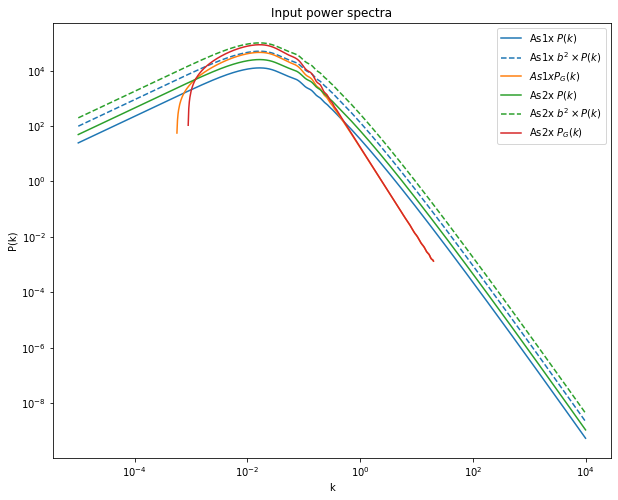

In [12]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(k1, Pk1, color='C0', label=r'As1x $P(k)$')
ax.plot(k1, Pk1*b**2, color='C0', ls='--', label=r'As1x $b^2\times P(k)$')
ax.plot(kG1, PkG1, color='C1', label=r'$As1x P_G(k)$')

ax.plot(k2, Pk2, color='C2', label=r'As2x $P(k)$')
ax.plot(k2, Pk2*b**2, color='C2', ls='--', label=r'As2x $b^2\times P(k)$')
ax.plot(kG2, PkG2, color='C3', label=r'As2x $P_G(k)$')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel('P(k)')
ax.set_title('Input power spectra')
ax.legend()

So we will use the galaxy matter spectrum calculated from the input matter power spectrum, i.e. $P_G(k) = (\mathrm{bias}^2)\ P(k)$, to compute our predicted variances.

### predicted variance in $\xi$ as a function of $r$

In [13]:
# ** predicted variance in the 2pcf at a certain length scale r
def xi_err_pred(r, V, n, k, Pk):

    # multiplicative constant
    const = 1 / (2*np.pi*V) # (2*np.pi)**5 / V

    # function of k that we want to integrate
    def k_func(k, Pk):
        return (k/r) * (Pk+(1/n))**2 * (special.jv(1/2, k*r))**2

    # construct our array, and integrate using trapezoid rule
    k_func_arr = np.array([k_func(k, Pk[i]) for i, k in enumerate(k)])
    trapz = integrate.trapz(k_func_arr, x=k)

    return const*trapz

In [14]:
def compute_predicted_xi_err_fixed_n(rs, k, Pk, n, kmin=None, kmax=None, bias=2.0):
    nbins = len(rs)
    
    # convert from matter power spectrum to galaxy power spectrum
    PkG_ = bias**2 * Pk

    # optionally, only integrate over part of the input power spectrum in k_func()
    idx = (k>kmin)&(k<kmax)
    k = k[idx]
    PkG_ = PkG_[idx]
    # print("after cuts:")
    # print(len(k), len(PkG_))

    # get predicted variances using xi_err_pred()
    pred_vars = np.empty(nbins)
    for i, r in enumerate(rs):
        pred_vars[i] = xi_err_pred(r, L**3, float(n), k, PkG_)

    return pred_vars

In [15]:
# k bounds
kmin = 2*np.pi/L
kmax = 20

imin1 = np.abs(k1 - kmin).argmin()
imax1 = np.abs(k1 - kmax).argmin()
print(k1[imin1], k1[imax1])
imin2 = np.abs(k2 - kmin).argmin()
imax2 = np.abs(k2 - kmax).argmin()
print(k1[imin2], k1[imax2])

0.0084556074 19.827593
0.0084556074 19.827593


In [16]:
rfine1 = np.linspace(min(r1), max(r1), 50)
rfine2 = np.linspace(min(r2), max(r2), 50)

In [21]:
# r_avg, k, Pk, kmin, kmax, and bias all defined above
kmaxs = [20]
pred_var_fixed_n1s = np.empty((len(kmaxs), len(rfine1)))
pred_var_fixed_n2s = np.empty((len(kmaxs), len(rfine2)))
for i, kmax_ in enumerate(kmaxs):
    pred_var_fixed_n1s[i] = compute_predicted_xi_err_fixed_n(rfine1, k1, Pk1, n, kmin=kmin, kmax=kmax_, bias=b)
    pred_var_fixed_n2s[i] = compute_predicted_xi_err_fixed_n(rfine2, k2, Pk2, n, kmin=kmin, kmax=kmax_, bias=b)

#### plot expected variance and compare to the simulation results

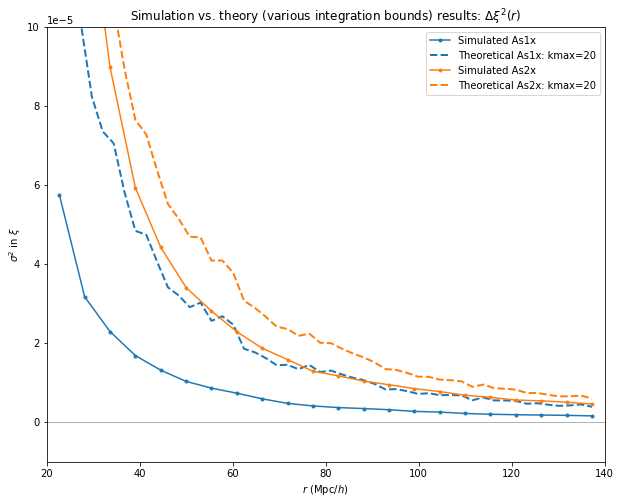

In [22]:
fig, ax = plt.subplots(figsize=(10,8))

# As1x is blue; theory is dashed
ax.plot(r1, xi_var1, marker='.', color='C0', alpha=1, label='Simulated As1x')
for i, pred_var in enumerate(pred_var_fixed_n1s):
    ax.plot(rfine1, pred_var, color='C0', ls='--', lw=2, alpha=1/(i+1), label=f'Theoretical As1x: kmax={kmaxs[i]}')

# As2x is orange; theory is dashed
ax.plot(r2, xi_var2, marker='.', color='C1', alpha=1, label='Simulated As2x')
for i, pred_var in enumerate(pred_var_fixed_n2s):
    ax.plot(rfine2, pred_var, color='C1', ls='--', lw=2, alpha=1/(i+1), label=f'Theoretical As2x: kmax={kmaxs[i]}')

ax.axhline(0, color='k', lw=1, alpha=0.3)
ax.set_xlim((20,140))
ax.set_ylim((-1e-5,1e-4))
ax.set_xlabel(r'$r$ (Mpc/$h$)')
ax.set_ylabel(r'$\sigma^2$ in $\xi$')
ax.set_title(r'Simulation vs. theory (various integration bounds) results: $\Delta\xi^2(r)$')
ax.legend()

For comparison, let's also plot the two different PkGs used in these calculations: the PkG used in theory prediction (i.e. bias^2 * Pk) and the PkG used to generate the mock catalogs– at the k range over which we integrated

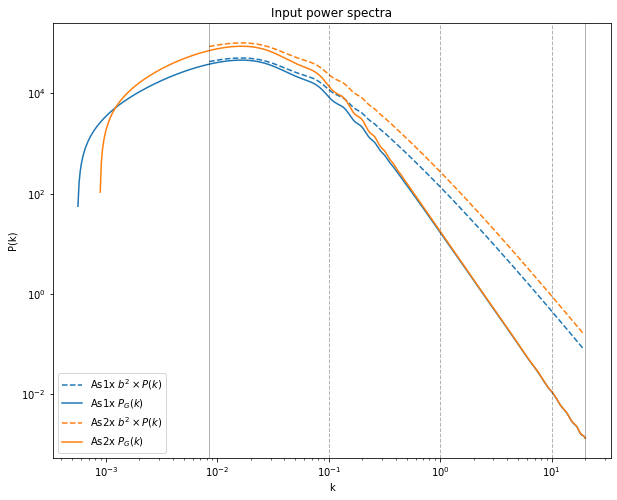

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

# As1x
ax.plot(k1[imin1:imax1], Pk1[imin1:imax1]*b**2, color='C0', ls='--', label=r'As1x $b^2\times P(k)$')
ax.plot(kG1, PkG1, color='C0', label=r'As1x $P_G(k)$')
# As2x
ax.plot(k2[imin2:imax2], Pk2[imin2:imax2]*b**2, color='C1', ls='--', label=r'As2x $b^2\times P(k)$')
ax.plot(kG2, PkG2, color='C1', label=r'As2x $P_G(k)$')

ax.axvline(k1[imin1], lw=1, color='k', alpha=0.3)
ax.axvline(k1[imax1], lw=1, color='k', alpha=0.3)

ax.axvline(.1, lw=1, ls='--', color='k', alpha=0.3)
ax.axvline(1, lw=1, ls='--', color='k', alpha=0.3)
ax.axvline(10, lw=1, ls='--', color='k', alpha=0.3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel('P(k)')
ax.set_title('Input power spectra')
ax.legend()

## EMPIRICAL RESULTS: $\,\Delta\xi^2(n)$

** Should I use As2x, or should I run Landy-Szalay on As1x?

In [37]:
# mock parameters
L = 750
ns = ['1e-6', '1e-5', '1e-4', '2e-4']  # L750_n4e-4 directory is empty in /ksf293
As2 = 2
nmocks = 1000

In [39]:
# load in Landy-Szalay results
xi_avgs = []
xi_stds = []
xi_vars = []
for i, n in enumerate(ns):
    mockset = MockSet(L, n, As=As2, data_dir=data_dir, rlzs=nmocks)
    mockset.load_xi_lss()
    r = mockset.r_avg
    xi_avg = np.mean(mockset.xi_lss, axis=0)
    xi_std = np.std(mockset.xi_lss, axis=0)
    xi_var = np.var(mockset.xi_lss, axis=0)
    xi_avgs.append(xi_avg)
    xi_stds.append(xi_std)
    xi_vars.append(xi_var)

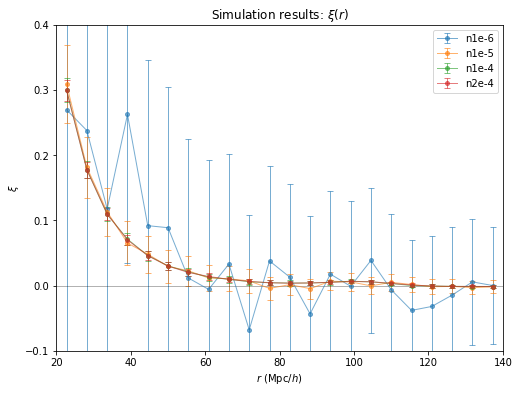

In [40]:
fig, ax = plt.subplots(figsize=(8,6))

for i, n in enumerate(ns):
    ax.errorbar(r, xi_avgs[i], xi_stds[i], marker='.', capsize=3, lw=1, alpha=0.6, ms=8, label=f'n{n}')

ax.axhline(0, color='k', lw=1, alpha=0.3)
ax.set_xlim((20,140))
ax.set_ylim((-0.1,0.4))
ax.set_xlabel(r'$r$ (Mpc/$h$)')
ax.set_ylabel(r'$\xi$')
ax.set_title(r'Simulation results: $\xi(r)$')
ax.legend()

### integrate over $r \, \Rightarrow \, \sigma^2_\xi$ as a function of number density $n$

We can start by trying the most simple thing, taking the average value of $\sigma^2_\xi(r)$ for each number density.

In [41]:
avg_vars = np.mean(xi_vars, axis=1)

Text(0.5, 1.0, 'Simulation results: $\\Delta\\xi^2(n)$')

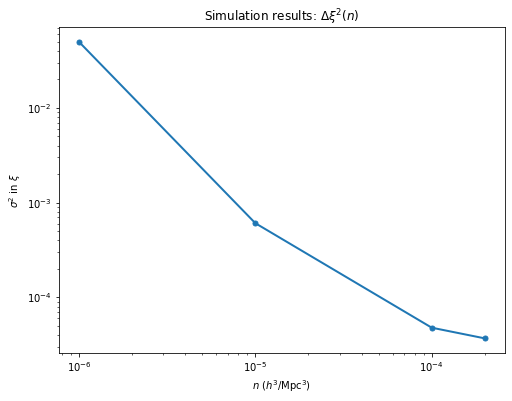

In [42]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot([float(n) for n in ns], avg_vars, marker='.', ms=10, lw=2)

ax.axhline(0, color='k', lw=1, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim((20,140))
# ax.set_ylim((-0.1,0.4))
ax.set_xlabel(r'$n$ ($h^3$/Mpc$^3$)')
ax.set_ylabel(r'$\sigma^2$ in $\xi$')
ax.set_title(r'Simulation results: $\Delta\xi^2(n)$')
# ax.legend()

## PREDICTED RESULTS: $\,\Delta\xi^2(n)$

In [43]:
# let's just choose kmax = 10 ?
kmax_ = 10

In [44]:
# rfine2, k2, Pk2, kmin, kmax, and bias all defined above
nfine = np.logspace(np.log10(min([float(n) for n in ns])), np.log10(max([float(n) for n in ns])), 20)
pred_var_fixed_ns = np.empty((len(nfine), len(rfine2)))
for i, n in enumerate(nfine):
    pred_var_fixed_ns[i] = compute_predicted_xi_err_fixed_n(rfine2, k2, Pk2, n, kmin=kmin, kmax=kmax_, bias=b)

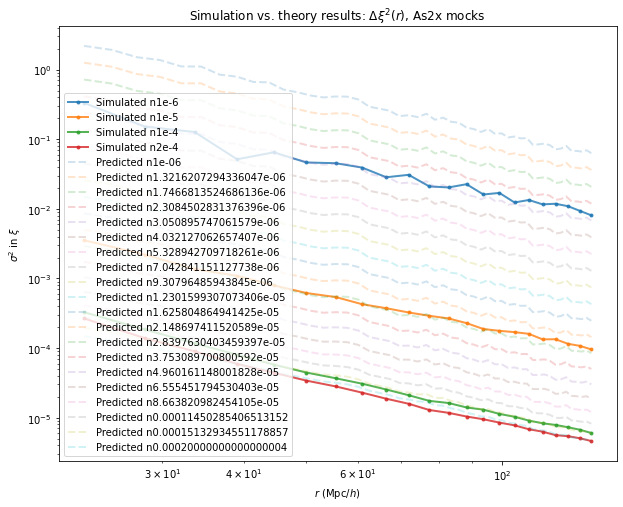

In [46]:
fig, ax = plt.subplots(figsize=(10,8))

cs = ['C0', 'C1', 'C2', 'C3']

for i, n in enumerate(ns):
    # simulated
    ax.plot(r, xi_vars[i], marker='.', color=cs[i], alpha=0.8, lw=2, label=f'Simulated n{n}')
for i, n in enumerate(nfine):
    # predicted
    ax.plot(rfine2, pred_var_fixed_ns[i], ls='--', lw=2, alpha=0.2, label=f'Predicted n{n}')

ax.axhline(0, color='k', lw=1, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim((20,140))
# ax.set_ylim((-1e-5,1e-4))
ax.set_xlabel(r'$r$ (Mpc/$h$)')
ax.set_ylabel(r'$\sigma^2$ in $\xi$')
ax.set_title(r'Simulation vs. theory results: $\Delta\xi^2(r)$, As2x mocks')
ax.legend()

In [50]:
# for each number density, get the average value of xi_var(r)
# to take the average val of a function: integrate the function over the interval
# and divide by the length of the interval
avg_vars_pred = np.empty(len(nfine))
for i, pred_var in enumerate(pred_var_fixed_ns):
    # integrate
    trapz = integrate.trapz(pred_var, x=rfine2)
    # divide by length
    avg_vars_pred[i] = trapz / (max(rfine2)-min(rfine2))

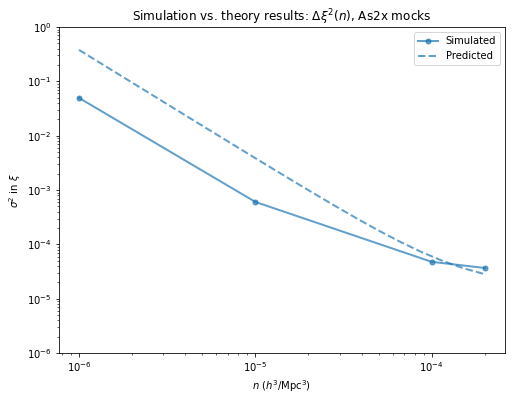

In [54]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot([float(n) for n in ns], avg_vars, marker='.', ms=10, lw=2, color='C0', alpha=0.7, label='Simulated')
ax.plot(nfine, avg_vars_pred, ls='--', lw=2, color='C0', alpha=0.7, label='Predicted')

ax.axhline(0, color='k', lw=1, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim((20,140))
ax.set_ylim((1e-6,1))
ax.set_xlabel(r'$n$ ($h^3$/Mpc$^3$)')
ax.set_ylabel(r'$\sigma^2$ in $\xi$')
ax.set_title(r'Simulation vs. theory results: $\Delta\xi^2(n)$, As2x mocks')
ax.legend()